# Sampler statistics

When checking for convergence or when debugging a badly behaving
sampler, it is often helpful to take a closer look at what the
sampler is doing. For this purpose some samplers export
statistics for each generated sample.

In [1]:
import pymc3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

%matplotlib inline

As a minimal example we sample from a standard normal distribution:

In [2]:
model = pymc3.Model()
with model:
    mu1 = pymc3.Normal("mu1", mu=0, sd=1, shape=10)

In [3]:
with model:
    step = pymc3.NUTS()
    trace = pymc3.sample(2000, tune=1000, init=None, step=step, njobs=2)

100%|██████████| 2000/2000 [00:02<00:00, 967.82it/s] 


NUTS provides the following statistics:

In [4]:
trace.stat_names

{'accept', 'depth', 'h_bar', 'step_size', 'step_size_bar', 'tree_size', 'tune'}

- `accept`: The mean acceptance probability across the trajectory for this sample. The mean of these values across all samples but the burn-in should be approximately `target_accept` (the default for this is 0.8). Values very close to zero usually indicate a diverging transition. (TODO Diverging transitions should have an explicit value!). If there are many of those, you might want to increase `target_accept` to something like 0.9 or 0.95.
- `depth`: The depth of the tree that was used to generate this sample
- `tree_size`: The number of leafs of the sampling tree, when the sample was accepted. This is usually a bit less than $2 ^ \text{depth}$. If the tree size is large, the sampler is using a lot of leapfrog steps to find the next sample. This can for example happen if there are strong correlations in the posterior, if the posterior has long tails, if there are regions of high curvature ("funnels"), or if the variance estimates in the mass matrix are inaccurate. Reparametrisation of the model or estimating the posterior variances from past samples might help.
- `tune`: This is `True`, if step size adaptation was turned on when this sample was generated.
- `step_size`: The step size used for this sample.
- `step_size_bar`: The current best known step-size. After the tuning samples, the step size is set to this value. This should converge during tuning.

If the name of the statistic does not clash with the name of one of the variables, we can use indexing to get the values. The values for the chains will be concatenated.

We can see that the step sizes converged after the 1000 tuning samples for both chains to about the same value. The first 2000 values are from chain 1, the second 2000 from chain 2.

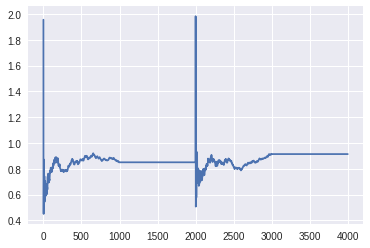

In [5]:
plt.plot(trace['step_size_bar'])

The `get_sampler_stats` method provides more control over which values should be returned, and it also works if the name of the statistic is the same as the name of one of the variables. We can use the `chains` option, to control values from which chain should be returned:

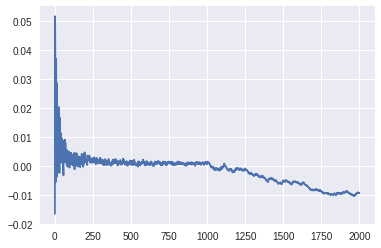

In [7]:
plt.plot(trace.get_sampler_stats('h_bar', chains=0))

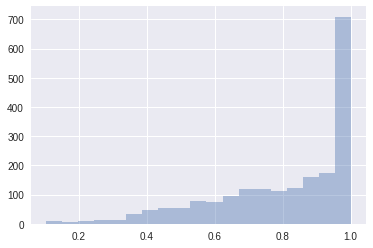

In [8]:
accept = trace.get_sampler_stats('accept', burn=1000)
sb.distplot(accept, kde=False)

In [9]:
accept.mean()

0.80628618748024605

# Multiple samplers

If multiple samplers are used for the same model (e.g. for continuous and discrete variables), the exported values are merged or stacked along a new axis.

In [10]:
model = pymc3.Model()
with model:
    mu1 = pymc3.Bernoulli("mu1", p=0.8)
    mu2 = pymc3.Normal("mu2", mu=0, sd=1, shape=10)

In [11]:
with model:
    step1 = pymc3.BinaryMetropolis([mu1])
    step2 = pymc3.Metropolis([mu2])
    trace = pymc3.sample(10000, init=None, step=[step1, step2], njobs=2, tune=1000)

100%|██████████| 10000/10000 [00:03<00:00, 2644.88it/s]


In [12]:
trace.stat_names

{'accept', 'p_jump', 'tune'}

Both samplers export `accept`, so we get one acceptance probability for each sampler:

In [13]:
trace.get_sampler_stats('accept')

array([[ 0.25      ,  0.06086744],
       [ 0.25      ,  0.1396085 ],
       [ 1.        ,  0.03764721],
       ..., 
       [ 1.        ,  0.28004152],
       [ 0.25      ,  0.43284722],
       [ 0.25      ,  0.05956353]])